<a href="https://colab.research.google.com/github/michl-in-pan/CropTypes/blob/master/download_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
%%capture
!pip install rasterio
!pip install sentinelhub
!pip install geopandas
!pip install geojson

import rasterio
import shapely.geometry
from sentinelhub import WmsRequest
from sentinelhub.constants import MimeType
from sentinelhub import SHConfig
from sentinelhub.time_utils import parse_time
from sentinelhub import FisRequest, BBox, Geometry, CRS, WcsRequest, CustomUrlParam, \
    DataCollection, HistogramType
from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import seaborn as sns
import os

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import geojson
from shapely.geometry import Point




In [23]:
!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/yields/yields2018.csv
!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/yields/FeldstueckeTUM/Feldstuecke_WGS84.shp
!wget https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/yields/FeldstueckeTUM/Feldstuecke_WGS84.shx

--2021-07-30 21:03:53--  https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/yields/yields2018.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15382706 (15M) [text/plain]
Saving to: ‘yields2018.csv.2’

yields2018.csv.2    100%[===================>]  14.67M  --.-KB/s    in 0.1s    

2021-07-30 21:03:53 (118 MB/s) - ‘yields2018.csv.2’ saved [15382706/15382706]

--2021-07-30 21:03:53--  https://raw.githubusercontent.com/ESA-PhiLab/WorldCrops/main/data/cropdata/Bavaria/yields/FeldstueckeTUM/Feldstuecke_WGS84.shp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

In [7]:
################################################################
# Sentinel Hub
################################################################


config = SHConfig()
config.instance_id = '5e98cacf-5c35-4e3b-9674-52c8241a01f1'
config.sh_client_id = '93c443b0-b60d-4ba3-b8e2-f05b9d5c47ac'
config.sh_client_secret = ')!sd9B)JKEF?eemyWf*8U|93iPXo5F:#mmbw/YWM'


if config.instance_id == '':
    print("Warning! To use FIS functionality, please configure the `instance_id`.")


# Configure your layer in the dashboard (configuration utility)
SHUB_LAYER_NAME1 = 'AGRICULTURE_L1C'
SHUB_LAYER_NAME2 = 'AGRICULTURE_L2A'

################################################################

In [8]:
# helper functions


def plot_image(image, factor=1, vmin=0, vmax=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image/10000 * factor, 1), vmin=vmin, vmax=vmax)
    else:
        plt.imshow(image, vmin=vmin, vmax=vmax)


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


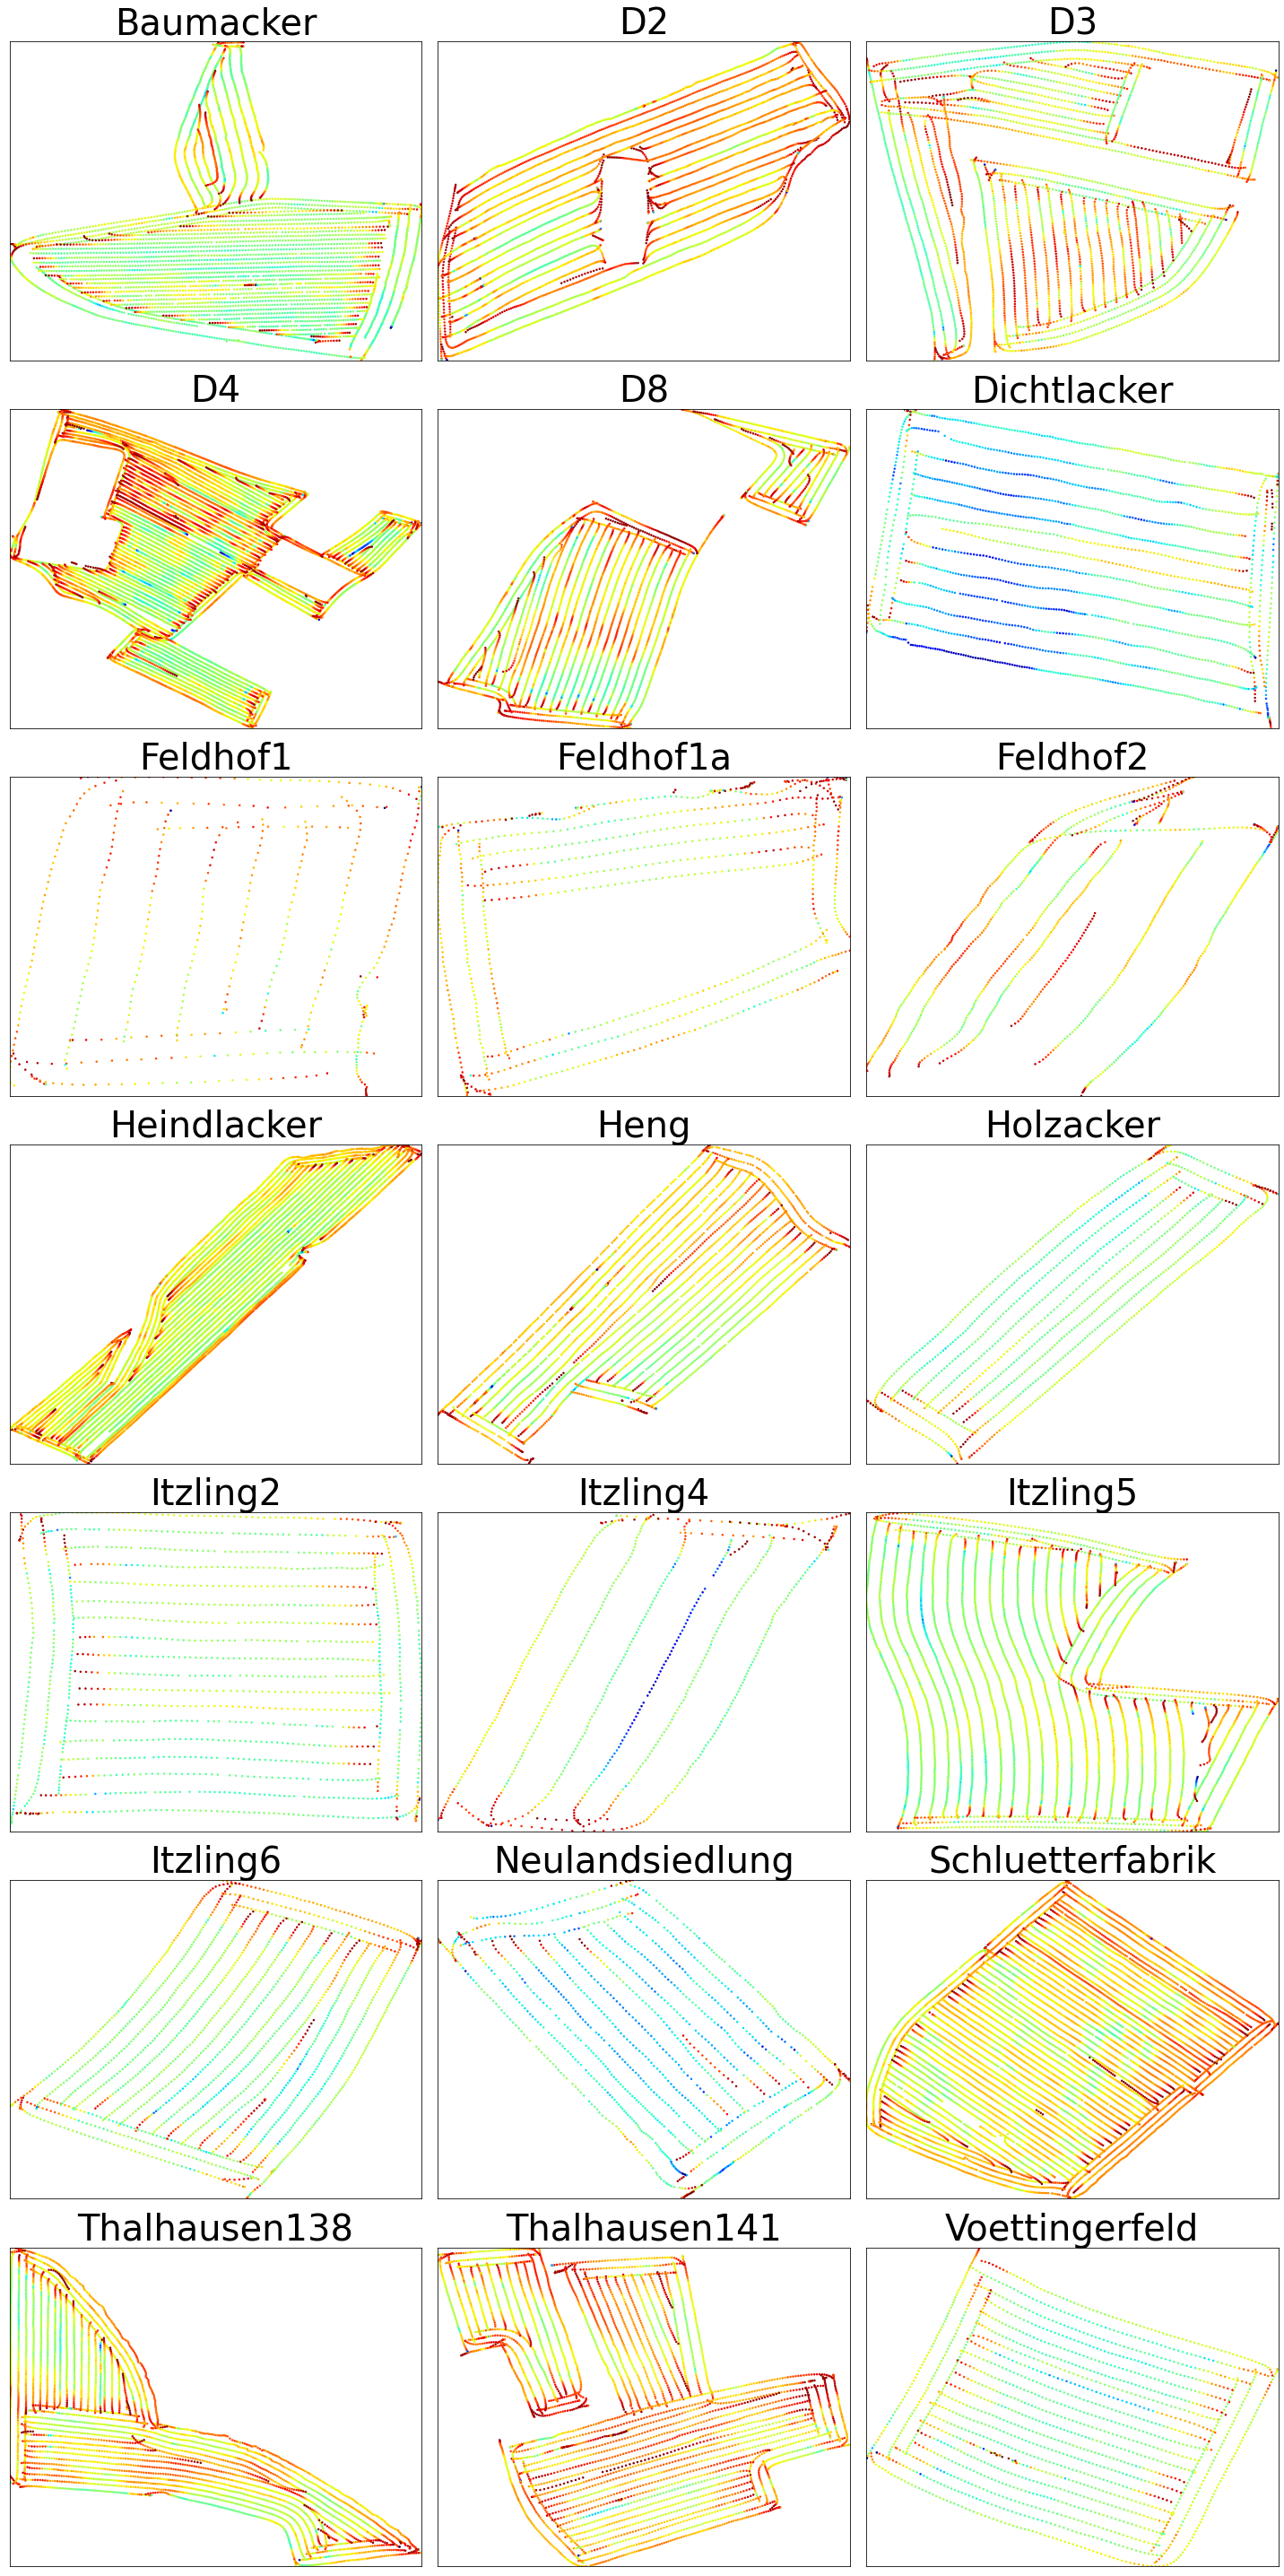

In [11]:
# %%
yields = pd.read_csv('yields2018.csv', sep=",",
                     encoding="ISO-8859-1", engine='python')
yields = yields[['Name', 'Latitude', 'Longitude', 'Elevation(m)', 'Ertr.masse (Nass)(tonne/ha)', 'Ertr.masse (Tr.)(tonne/ha)',
                 'Ertr.vol (Tr.)(L/ha)', 'ErtragNass', 'ErtragTr', 'Feuchtigkeit(%)', 'Jahr', 'TAG']]

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14,
    ax15), (ax16, ax17, ax18), (ax19, ax20, ax21)) = plt.subplots(7, 3, figsize=(20, 40))
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11,
           ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, ax21]
size = 40
_tmp2 = yields
# Muehlacker rausgenommen obwohl WW damit bild quadratisch wird
gerste = ['Muehlacker', 'Grafenfeld', 'Krohberg', 'Radarstation', 'Sieblerfeld', 'Striegelfeld', 'Viehhausen1', 'Viehhausen11', 'Viehhausen3', 'Viehhausen5'
          ]
_tmp2 = _tmp2[~_tmp2.Name.isin(gerste)]

names = _tmp2['Name'].unique().tolist()
# print(len(names),names)
for i in range(len(names)):
    field = _tmp2[_tmp2.Name == names[i]]
    # print(i,names[i])
    geometry = [Point(xy) for xy in zip(field.Longitude, field.Latitude)]
    crs = {'init': 'epsg:4326'}
    gdf = gpd.GeoDataFrame(field, crs=crs, geometry=geometry)

    minx, miny, maxx, maxy = gdf.total_bounds
    # print(ax_list[i])
    ax_list[i].set_xlim(minx, maxx)
    ax_list[i].set_ylim(miny, maxy)
    ax_list[i].axes.get_xaxis().set_visible(False)
    ax_list[i].axes.get_yaxis().set_visible(False)
    txt = names[i]
    ax_list[i].set_title(txt, fontsize=size)
    ax_list[i].scatter(y=field.Latitude, x=field.Longitude, alpha=1, cmap=plt.get_cmap(
        "jet_r"), c=field['Ertr.masse (Nass)(tonne/ha)'], s=2.2)

# plt.xlabel("Test")
#plt.ylabel("common Y")

#cb_ax = f.add_axes([0.92, 0.05, 0.02, 0.9])
# cb_ax.tick_params(labelsize=40)

f.tight_layout()

# f.subplots_adjust(right=0.9)

In [12]:
f.savefig('test.png')

In [63]:
# read TUM field data
tum = gpd.read_file("Feldstuecke_WGS84.shp")
tum.columns

Index(['FID_1', 'Nummer', 'Name', 'Jahr', 'Land', 'Betrieb', 'Flaeche',
       'LFlaeche', 'Shape_Leng', 'Shape_Area', 'Name_new', 'geometry'],
      dtype='object')

In [64]:
fields_with_yields = ['Baumacker', 'D8', 'Dichtlacker', 'Heindlacker', 'Heng', 'Holzacker', 'Neulandsiedlung',
                      'Itzling2', 'Itzling5', 'Itzling6', 'Schluetterfabrik', 'Thalhausen138', 'Thalhausen141', 'Voettingerfeld']

# get the polygon of all considered fields.
#filtered_fields = tum[tum.Name_new.isin(fields_with_yields)]
#filtered_fields = pd.concat([wheat_area, filtered_fields], ignore_index=True)
filtered_fields = tum[tum.Name_new.isin(yields.Name.unique())]

# %%
# one multipoly for the area with fields
tmp = filtered_fields.geometry.unary_union
gdf2 = gpd.GeoDataFrame(geometry=[tmp], crs=filtered_fields.crs)
allfields = shapely.geometry.box(*gdf2.total_bounds)
resolution = 10
field = BBox((allfields), CRS.WGS84)
field_size = bbox_to_dimensions(field, resolution=resolution)
time_interval = ('2018-02-01', '2018-05-01')



In [65]:
len(filtered_fields)

31

In [66]:
# download all data
def download_field_data(name, polygon, timeinterval):
    resolution = 10
    field = BBox((polygon), CRS.WGS84)

    request = WmsRequest(
        data_collection=DataCollection.SENTINEL2_L1C,
        data_folder='GAN_data/'+name,
        layer='AGRICULTURE_L2A_GAN',
        bbox=field,
        custom_url_params={CustomUrlParam.GEOMETRY: polygon},
        time=time_interval,
        width=512,
        maxcc=0.1,
        image_format=MimeType.TIFF,
        config=config
    )
    dem_request = WmsRequest(
        data_collection=DataCollection.DEM,
        data_folder='DEM/'+name,
        layer='DEM',
        bbox=field,
        width=512,
        image_format=MimeType.TIFF,
        custom_url_params={CustomUrlParam.GEOMETRY: polygon},
        config=config
    )

    #data = request.get_data(redownload=True)
    #dem = dem_request.get_data(redownload=True)
    dem_request.save_data()
    request.save_data()
    # return data

In [68]:
time_interval = ('2018-02-01', '2018-09-01')
#filtered_fields = filtered_fields.head(3)
len(filtered_fields)



31

In [ ]:
for idx, field in filtered_fields.iterrows():
    name = field.Name_new
    polygon = field.geometry
    download_field_data(name, polygon, time_interval)
    # imagedata.download_list[0]

In [44]:
# %%
with rasterio.open('GAN_data/Schluetterfabrik/065c759f19f43e882d0f1cf4dd7a8b88/response.tiff', 'r') as ds:
    arr = ds.read()  # read all raster values



In [47]:
arr.shape

(512, 559, 14)

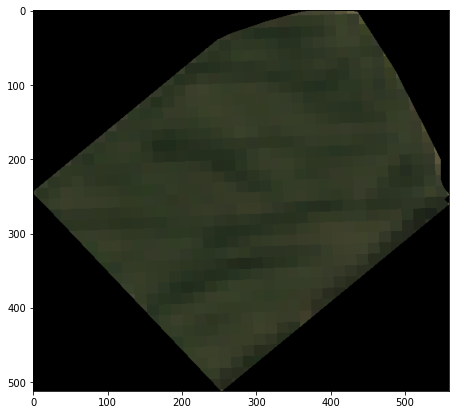

In [51]:
arr = np.moveaxis(arr, 0, -1)
arr = np.moveaxis(arr, 1, 0)
# %%
plot_image(arr[:, :, [5, 4, 3]], 2.5)